/opt/conda/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


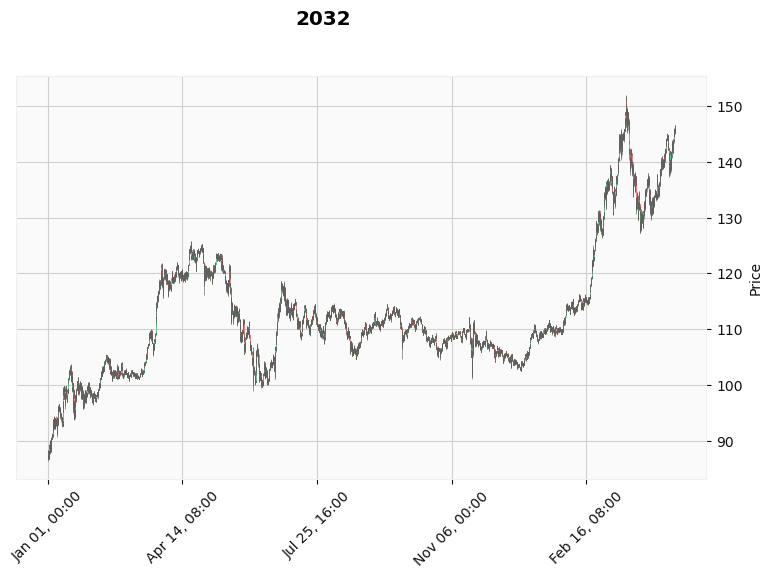

In [1]:
!pip install h5py --upgrade
!pip install mplfinance
import h5py
import pandas as pd
import mplfinance as mpf
dataset = "2032"

def hdf5_to_dataframe(hdf5_file, table_name):
    with h5py.File(hdf5_file, 'r') as f:
        data = f[table_name][:]
        df = pd.DataFrame(data)
        
        # Convert the datetime column from milliseconds to seconds
        df[0] = df[0] / 1000
        
        # Convert the Unix timestamp to standard datetime format
        df[0] = pd.to_datetime(df[0], unit='s')
        
        # Set the datetime column as the index
        df.set_index(0, inplace=True)
        
        return df

file_path = "backtest_optimizer/data/dukascopy.h5"

df = hdf5_to_dataframe(file_path, dataset)
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df.loc['2013':]
df = df.resample('h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})
mpf.plot(df, type='candle', style='yahoo', title=dataset, figratio=(10, 6))

df['group_ids'] = 'group'
df['series'] = range(len(df))
df = df.reset_index()
df['time_idx'] = range(len(df))
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df.columns = [str(col).replace(".", "_") for col in df.columns]
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

In [2]:
df.head()

,0,Close,group_ids,series,time_idx
0,2013-01-01 00:00:00,86.688,group,0,0
1,2013-01-01 01:00:00,86.688,group,1,1
2,2013-01-01 02:00:00,86.688,group,2,2
3,2013-01-01 03:00:00,86.688,group,3,3
4,2013-01-01 04:00:00,86.688,group,4,4


In [3]:
contains_nan = df.isna().any().any()

print(contains_nan)

False


In [4]:
tomorrow_forecast_data = df.iloc[-336:]

In [5]:
train_data = df.iloc[:-336]

In [6]:
from datetime import timedelta

# Assuming df is your DataFrame
tomorrow_forecast_data

# Get the last value of the '0', 'Close', 'group_ids', 'series', and 'time_idx' columns
last_datetime = pd.to_datetime(tomorrow_forecast_data.iloc[-1, 0])
last_close = tomorrow_forecast_data.iloc[-1, 1]
last_group_ids = tomorrow_forecast_data.iloc[-1, 2]
last_series = tomorrow_forecast_data.iloc[-1, 3]
last_time_idx = tomorrow_forecast_data.iloc[-1, 4]

# Create new DataFrame
new_data = pd.DataFrame({
    '0': [last_datetime + timedelta(hours=i) for i in range(1, 169)],
    'Close': [last_close]*168,
#    'Close': [last_close + i/100 for i in range(1, 169)],
    'group_ids': [last_group_ids]*168,
    'series': [last_series + i for i in range(1, 169)],
    'time_idx': [last_time_idx + i for i in range(1, 169)]
})

# Concatenate df with new_data
tomorrow_forecast_data = pd.concat([tomorrow_forecast_data, new_data], ignore_index=True)

In [7]:
import pandas as pd
import os
import warnings
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, SMAPE
from pytorch_lightning.callbacks import EarlyStopping

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

# Time series forecasting
max_encoder_length = 336
max_prediction_length = 168
training_cutoff = train_data['time_idx'].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length



training_dataset_timeseries = TimeSeriesDataSet(
    train_data[lambda x: x['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=["group_ids"],
    time_varying_unknown_reals=["Close"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

forecast_dataset_timeseries = TimeSeriesDataSet(
    data=tomorrow_forecast_data,
    time_idx="time_idx",
    target="Close",
    group_ids=["group_ids"],
    time_varying_unknown_reals=["Close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    predict_mode=True  # set predict_mode to True for prediction
)

batch_size = 128
forecast_dataloader = forecast_dataset_timeseries.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

validation_dataset_timeseries = TimeSeriesDataSet.from_dataset(training_dataset_timeseries, train_data, min_prediction_idx=training_cutoff + 1)
train_dataloader = training_dataset_timeseries.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset_timeseries.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [8]:
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

/opt/conda/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://

tensor(0.0076, device='cuda:0')

In [9]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
from sklearn.base import BaseEstimator
import torch
from torch import distributions, nn
import torch.nn.functional as F

from pytorch_forecasting.data.encoders import TorchNormalizer, softplus_inv
from pytorch_forecasting.metrics.base_metrics import DistributionLoss, MultivariateDistributionLoss


from pytorch_forecasting.metrics import NormalDistributionLoss, SMAPE
class ANDL(NormalDistributionLoss):
    """
    Absolute normal distribution loss as a child of NormalDistributionLoss.
    """

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        distr = self.distribution_class(loc=torch.abs(x[..., 2]), scale=torch.abs(x[..., 3]))
        scaler = distributions.AffineTransform(loc=torch.abs(x[..., 0]), scale=torch.abs(x[..., 1]))
        if self._transformation is None:
            return distributions.TransformedDistribution(distr, [scaler])
        else:
            return distributions.TransformedDistribution(
                distr, [scaler, TorchNormalizer.get_transform(self._transformation)["inverse_torch"]]
            )

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self._transformation = encoder.transformation
        loc = torch.abs(parameters[..., 0])
        scale = F.softplus(torch.abs(parameters[..., 1]))
        return torch.concat(
            [target_scale.unsqueeze(1).expand(-1, loc.size(1), -1), loc.unsqueeze(-1), scale.unsqueeze(-1)], dim=-1
        )

In [10]:

pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training_dataset_timeseries,
    learning_rate=3e-2,
    hidden_size=840,
    rnn_layers=4,
    loss=ANDL(),
    optimizer="Adam",
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


/opt/conda/lib/python3.8/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` ini

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0005011872336272722
Restoring states from the checkpoint path at /workspace/Desktop/.lr_find_24cf3fe7-c401-4d7f-9d0b-e881f688fd14.ckpt
Restored all states from the checkpoint at /workspace/Desktop/.lr_find_24cf3fe7-c401-4d7f-9d0b-e881f688fd14.ckpt


suggested learning rate: 0.0005011872336272722


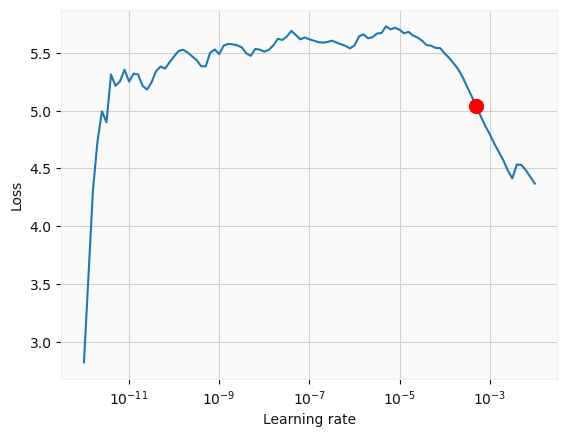

In [11]:
  # find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-12,
    max_lr=1e-2,
    early_stop_threshold=1000,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [12]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=10000,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    logger=logger,
)


net = DeepAR.from_dataset(
    training_dataset_timeseries,
    learning_rate=res.suggestion(),#3.548133892335755e-05,#1e-2,#,
    log_interval=10,
    log_val_interval=1,
    hidden_size=840,
    rnn_layers=4,
    optimizer="Adam",
    loss=ANDL(),#NormalDistributionLoss(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type           | Params
----------------------------------------------------------
0 | loss                   | ANDL           | 0     
1 | logging_metrics        | ModuleList     | 0     
2 | embeddings             | MultiEmbedding | 0     
3 | rnn                    | LSTM           | 19.8 M
4 | distribution_projector | Linear         | 1.7 K 
----------------------------------------------------------
19.8 M    Trainable params
0         Non-trainable params
19.8 M    Total params
79.155    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
MAE()(predictions.output, predictions.y)

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=1000, trainer_kwargs=dict(accelerator="gpu")
)

In [ ]:
for idx in range(1):  # plot example
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_forecast = raw_predictions.output[0][0].cpu().numpy()

mean_forecast = np.mean(mean_forecast, axis=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the stock prices
ax.plot(mean_forecast)

# Set title and labels for axes
ax.set_title("mean_forecast")
ax.set_xlabel("Time")
ax.set_ylabel("Price")

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lower_bound_forecast = raw_predictions.output[0][0].cpu().numpy()

lower_bound_forecast = np.percentile(lower_bound_forecast, 50, axis=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the stock prices
ax.plot(lower_bound_forecast)

# Set title and labels for axes
ax.set_title("lower_bound_forecast")
ax.set_xlabel("Time")
ax.set_ylabel("Price")

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

upper_bound_forecast = raw_predictions.output[0][0].cpu().numpy()

upper_bound_forecast = np.percentile(upper_bound_forecast, 75, axis=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the stock prices
ax.plot(upper_bound_forecast)

# Set title and labels for axes
ax.set_title("upper_bound_forecast")
ax.set_xlabel("Time")
ax.set_ylabel("Price")

# Display the plot
plt.show()

In [ ]:
if np.mean(mean_forecast, axis=0) > mean_forecast[0]:
    prediction = 'long'
else:
    prediction = 'short'
if prediction == 'long':
    print(f"long = {np.mean(mean_forecast, axis=0)}, TP = {np.max(upper_bound_forecast, axis=0)}, SL = {np.min(lower_bound_forecast, axis=0)}")
else:
    print(f"short = {np.mean(mean_forecast, axis=0)}, TP = {np.min(lower_bound_forecast, axis=0)}, SL = {np.max(upper_bound_forecast, axis=0)}")


In [ ]:
predictions = best_model.predict(forecast_dataloader, trainer_kwargs=dict(accelerator="gpu"))

predictions = best_model.predict(forecast_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
MAE()(predictions.output, predictions.y)

raw_predictions = net.predict(
    forecast_dataloader, mode="raw", return_x=True, n_samples=1000, trainer_kwargs=dict(accelerator="gpu")
)

for idx in range(1):  # plot example
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)